In [ ]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [31]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# thresholding voxels based on their R2 for this model
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

vox_prf_inds = np.concatenate([out[si]['best_params'][5][:,0] for si in range(n_subjects)], axis=0)

#### Get info about the Gabor feature space

In [3]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [5]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
assert(not(np.any(is_constant)))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


#### Histograms of preferred features

In [ ]:
n_vox = preferred_ori_corr.shape[0]
feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr[vv])
    ff = int(preferred_sf_corr[vv])
    feature_prefs_2dhist[vv,oo,ff] = 1

#### Now compute ROI-averaged response profiles
For each participant separately

In [ ]:
avg_resp_profiles = np.zeros((n_subjects, n_rois, n_ori, n_sf))
for si in range(n_subjects):
    for ri in range(n_rois):        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)   
        avg_resp_profiles[si,ri,:,:] = np.mean(allcorr_reshaped[inds_this_roi,:,:], axis=0)

#### Load image stats analysis

In [51]:
from analyze_features import load_feature_stats
from model_fitting import initialize_fitting 

feature_type='gabor_solo'
subject=999

mean, var, covar = \
        load_feature_stats.load_feature_stats(feature_type, subject=subject)

partial_corr, partial_nsamp, partial_names, partial_signed_names = \
        load_feature_stats.load_feature_semantic_partial_corrs(feature_type, subject=subject,\
                                                               which_axes_negate = [1,2],
                                                       min_samp=20, verbose=True)

n_partial_discrim_types = partial_corr.shape[2]
axes_to_do_partial = [0,2,3]

models = initialize_fitting.get_prf_models(which_grid=5)
n_prfs = len(models)

mean_reshaped = np.reshape(mean, [n_ori, n_sf, n_prfs], order = 'F')
var_reshaped = np.reshape(var, [n_ori, n_sf, n_prfs], order = 'F')
 
sem_corr_reshaped = np.reshape(partial_corr, [n_ori, n_sf, n_prfs, len(axes_to_do_partial)], order='F')

In [50]:
# corr, _, _, _, signed_names = \
#         load_feature_stats.load_feature_semantic_corrs(feature_type, subject=subject, \
#                                                        which_axes_negate = [1,2,3], \
#                                                        min_samp=10, verbose=False)
# corr = corr[:,:,[0,2,3]]
# signed_names = np.array(signed_names)[[0,2,3]]

# sem_corr_reshaped = np.reshape(corr, [n_ori, n_sf, n_prfs, len(axes_to_do_partial)], order='F')


In [10]:
partial_signed_names

['outdoor > indoor', 'animate > inanimate', 'small > large']

#### Correlate each voxel's sensitivity profile with the diagnostic feature channels for each semantic axis

In [52]:
n_vox = allcorr_reshaped.shape[0]
n_dims = n_partial_discrim_types
tuning_dim_corrs = np.zeros((n_vox,n_dims))
tuning_var_corrs = np.zeros((n_vox,))
tuning_mean_corrs = np.zeros((n_vox,))

for vv in range(n_vox):
    
    if np.mod(vv,5000)==0:
        print('%d/%d'%(vv, n_vox))
        
    # selectivity of the current voxel for each channel
    vox_vals = allcorr_reshaped[vv,:,:].ravel()
        
    prf_ind = vox_prf_inds[vv]
    
    # mean_vals = mean_reshaped[:,:,prf_ind].ravel()
    # var_vals = var_reshaped[:,:,prf_ind].ravel()
    mean_vals = np.mean(mean_reshaped, axis=2).ravel()
    var_vals = np.mean(var_reshaped, axis=2).ravel()
    
    tuning_mean_corrs[vv] = np.corrcoef(mean_vals, vox_vals)[0,1]
    tuning_var_corrs[vv] = np.corrcoef(var_vals, vox_vals)[0,1]
    
    for dim in range(n_dims):
        
        # sem_vals = sem_corr_reshaped[:,:,prf_ind,dim].ravel()
        sem_vals = np.mean(sem_corr_reshaped[:,:,:,dim], axis=2).ravel()

        # raw correlation
        tuning_dim_corrs[vv,dim] = np.corrcoef(sem_vals, vox_vals)[0,1]

0/150842
5000/150842
10000/150842
15000/150842
20000/150842
25000/150842
30000/150842
35000/150842
40000/150842
45000/150842
50000/150842
55000/150842
60000/150842
65000/150842
70000/150842
75000/150842
80000/150842
85000/150842
90000/150842
95000/150842
100000/150842
105000/150842
110000/150842
115000/150842
120000/150842
125000/150842
130000/150842
135000/150842
140000/150842
145000/150842
150000/150842


#### Correlate with mean/variance each feature channel

In [53]:
roi_tuning_mean_corrs = np.zeros((n_subjects, n_rois))
roi_tuning_var_corrs = np.zeros((n_subjects, n_rois))
roi_tuning_dim_corrs = np.zeros((n_subjects, n_rois, n_dims))

for si in range(n_subjects):
    
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)
     
        roi_tuning_mean_corrs[si,ri] = np.mean(tuning_mean_corrs[inds_this_roi], axis=0)
        roi_tuning_var_corrs[si,ri] = np.mean(tuning_var_corrs[inds_this_roi], axis=0)
        roi_tuning_dim_corrs[si,ri,:] = np.mean(tuning_dim_corrs[inds_this_roi,:], axis=0)


In [24]:
roi_tuning_mean_corrs2 = np.zeros((n_subjects, n_rois))
roi_tuning_var_corrs2 = np.zeros((n_subjects, n_rois))
roi_tuning_dim_corrs2 = np.zeros((n_subjects, n_rois, n_dims))

var_vals = np.mean(var_reshaped, axis=2)
mean_vals = np.mean(mean_reshaped, axis=2)

for si in range(n_subjects):
    
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)
     
        roi_vals = np.mean(allcorr_reshaped[inds_this_roi,:,:], axis=0)
        
        roi_tuning_mean_corrs2[si,ri] = np.corrcoef(mean_vals.ravel(), roi_vals.ravel())[0,1]
        roi_tuning_var_corrs2[si,ri] = np.corrcoef(var_vals.ravel(), roi_vals.ravel())[0,1]
        
        for dim in range(n_dims):
   
            # semantic diagnosticity of each feature channel
            sem_vals = np.mean(sem_corr_reshaped[:,:,:,dim], axis=2)

            roi_tuning_dim_corrs2[si,ri,dim] = np.corrcoef(sem_vals.ravel(), roi_vals.ravel())[0,1]


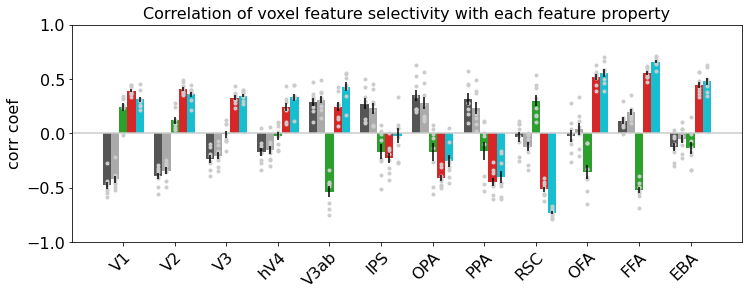

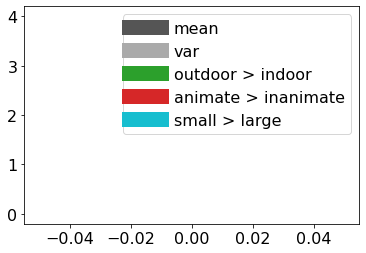

In [54]:
colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]
colors_gray = cm.gray(np.linspace(0,1,4))[1:3,:]
colors = np.concatenate([colors_gray, colors], axis=0)

roi_mean_vals = np.concatenate([roi_tuning_mean_corrs[:,:,None], \
                                roi_tuning_var_corrs[:,:,None], \
                                roi_tuning_dim_corrs], axis=2)
# roi_mean_vals = np.concatenate([roi_tuning_mean_corrs2[:,:,None], \
#                                 roi_tuning_var_corrs2[:,:,None], \
#                                 roi_tuning_dim_corrs2], axis=2)

mean_vals = np.mean(roi_mean_vals, axis=0)
sem_vals = np.std(roi_mean_vals, axis=0)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
title='Correlation of voxel feature selectivity with each feature property'

bw = 0.16;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = roi_mean_vals, \
                                colors=colors, space=space, \
            xticklabels=roi_names, ylabel='corr coef', \
            ylim=[-1.0, 1.0], title=title, horizontal_line_pos=0,\
            legend_labels=['mean','var']+partial_signed_names, \
            legend_overlaid=False, legend_separate=True, \
            fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)

#### Plot average 2d resp profiles for each ROI

Text(0.5, 0.98, 'sensitivity profile, averaged within ROIs\ncombined S1, S2, S3, S4, S5, S6, S7, S8')

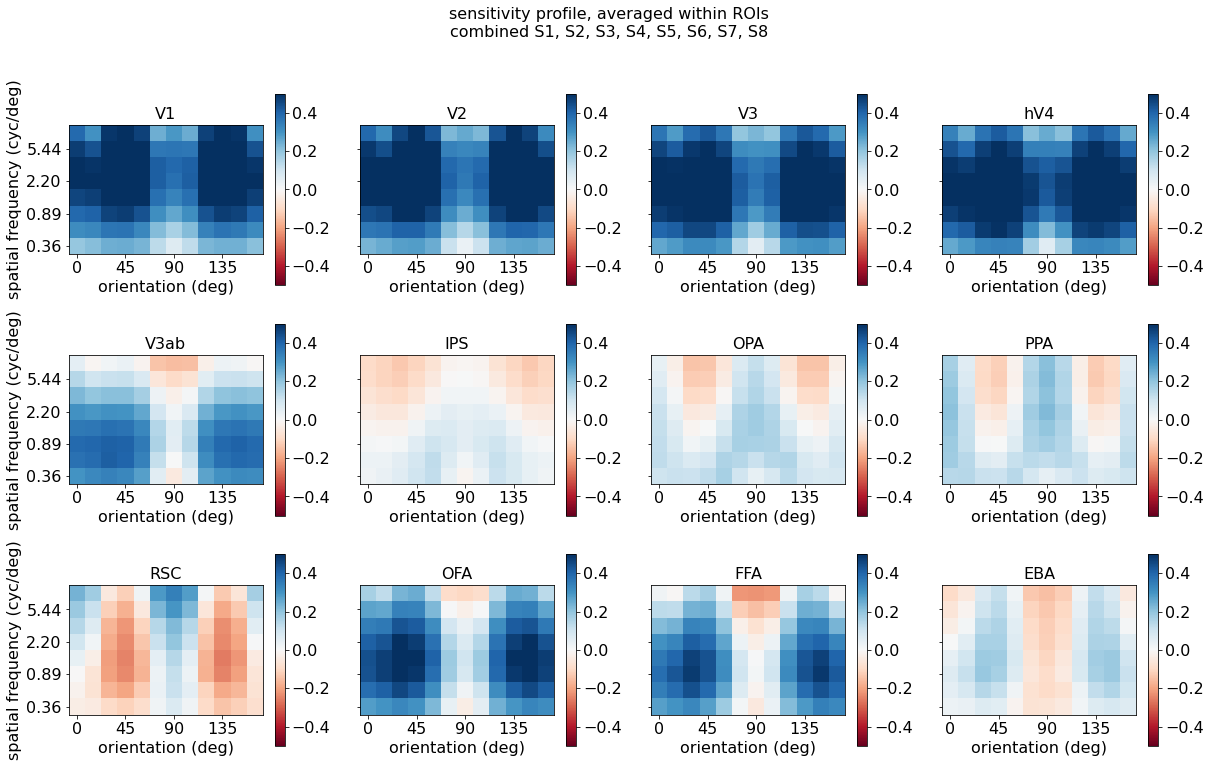

In [15]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

clims = [-0.5, 0.5]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=0)
    
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr,4)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        plt.ylabel('spatial frequency (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
    # plt.axis('off')
    
    plt.colorbar()

    plt.xlabel('orientation (deg)')
   
    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

# fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
# plt.savefig(fn2save)

In [16]:
rinds1 = np.array([6,7,8])
rinds2 = np.array([9,10])
print(np.array(roi_names)[rinds1])
print(np.array(roi_names)[rinds2])
      

['OPA' 'PPA' 'RSC']
['OFA' 'FFA']


Text(0.5, 1.0, 'face - place')

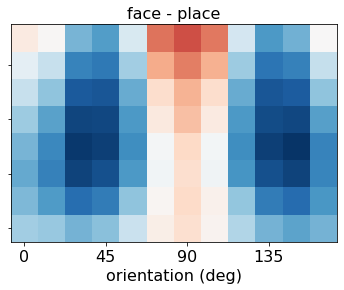

In [17]:
vals2 = np.mean(np.mean(avg_resp_profiles[:,rinds2,:,:], axis=0), axis=0)
vals1 = np.mean(np.mean(avg_resp_profiles[:,rinds1,:,:], axis=0), axis=0)
vals = vals2 - vals1

clims = [-0.6, 0.6]
plt.figure()
plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
sf_ticks = sf_unique[[0,2,4,6]].round(2)
if np.mod(rr,4)==0:
    plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
    plt.ylabel('spatial frequency (cyc/deg)')
else:
    plt.yticks(np.array([0,2,4,6])+0.5,[])
plt.axis('square')
plt.xlim([0,12])
plt.ylim([0,8])
# plt.axis('off')

plt.xlabel('orientation (deg)')

plt.title('face - place')

#### Compute the unique variance in each voxel's feature sensitivity values explained by mean/var and semantic diagnosticity

In [20]:
from utils import stats_utils 

mvals = np.mean(mean_reshaped, axis=2)
vvals = np.mean(var_reshaped, axis=2)

x_meanvar = np.array([mvals.ravel(), vvals.ravel()]).T

# all semantic dims concatenated
semvals = np.mean(sem_corr_reshaped, axis=2)
n_dims = n_partial_discrim_types

x_sem = np.reshape(semvals, [n_ori*n_sf,n_dims])

x_combined = np.concatenate([x_meanvar, x_sem], axis=1)

x_leaveout0 = np.concatenate([x_meanvar, x_sem[:,[1,2]]], axis=1)
x_leaveout1 = np.concatenate([x_meanvar, x_sem[:,[0,2]]], axis=1)
x_leaveout2 = np.concatenate([x_meanvar, x_sem[:,[0,1]]], axis=1)

xnames = ['meanvar','allsem','all','leaveout0','leaveout1','leaveout2']
xlist = [x_meanvar, x_sem, x_combined, x_leaveout0, x_leaveout1, x_leaveout2]

n_vox = allcorr_reshaped.shape[0]

r2_linreg = np.zeros((n_vox, len(xnames)))

# for vv in range(10):
for vv in range(n_vox):
    
    yvals = allcorr_reshaped[vv,:,:]

    y = yvals.ravel()[:,None]

    for ii, x in enumerate(xlist):
                     
        yhat, reg_coeffs, r2 = stats_utils.lin_reg(x,y)

        r2_linreg[vv,ii] = r2

In [21]:
roi_r2_linreg = np.zeros((n_subjects, n_rois, r2_linreg.shape[1]))

for si in range(n_subjects):
    
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)
        
        roi_r2_linreg[si,ri,:] = np.mean(r2_linreg[inds_this_roi,:], axis=0)
        

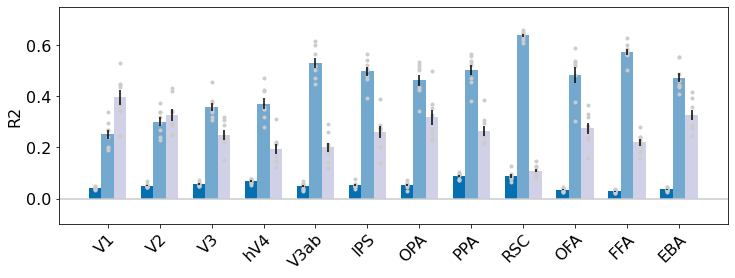

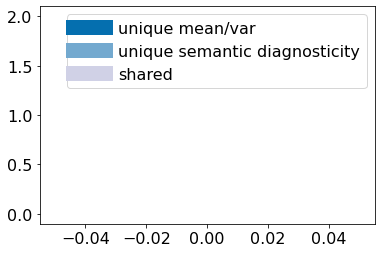

In [22]:
colors = np.flipud(cm.PuBu(np.linspace(0,1,5))[1:4,:])

# unique mean/var, unique sem diagnosticity, shared
roi_mean_vals = np.moveaxis(np.array([roi_r2_linreg[:,:,2] - roi_r2_linreg[:,:,1], \
                      roi_r2_linreg[:,:,2] - roi_r2_linreg[:,:,0], \
                      roi_r2_linreg[:,:,0]+roi_r2_linreg[:,:,1]-roi_r2_linreg[:,:,2]]), [0],[2])

mean_vals = np.mean(roi_mean_vals, axis=0)
sem_vals = np.std(roi_mean_vals, axis=0)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
# title='Avg correlation of voxel feature selectivity with semantic diagnosticity of features'
title=''

bw = 0.24;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = roi_mean_vals, \
                                colors=colors, space=space, \
            xticklabels=roi_names, ylabel='R2', \
            ylim=[-0.1, 0.75], title=title, horizontal_line_pos=0,\
            legend_labels=['unique mean/var', 'unique semantic diagnosticity','shared'],
            legend_overlaid=False, legend_separate=True, \
            fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)

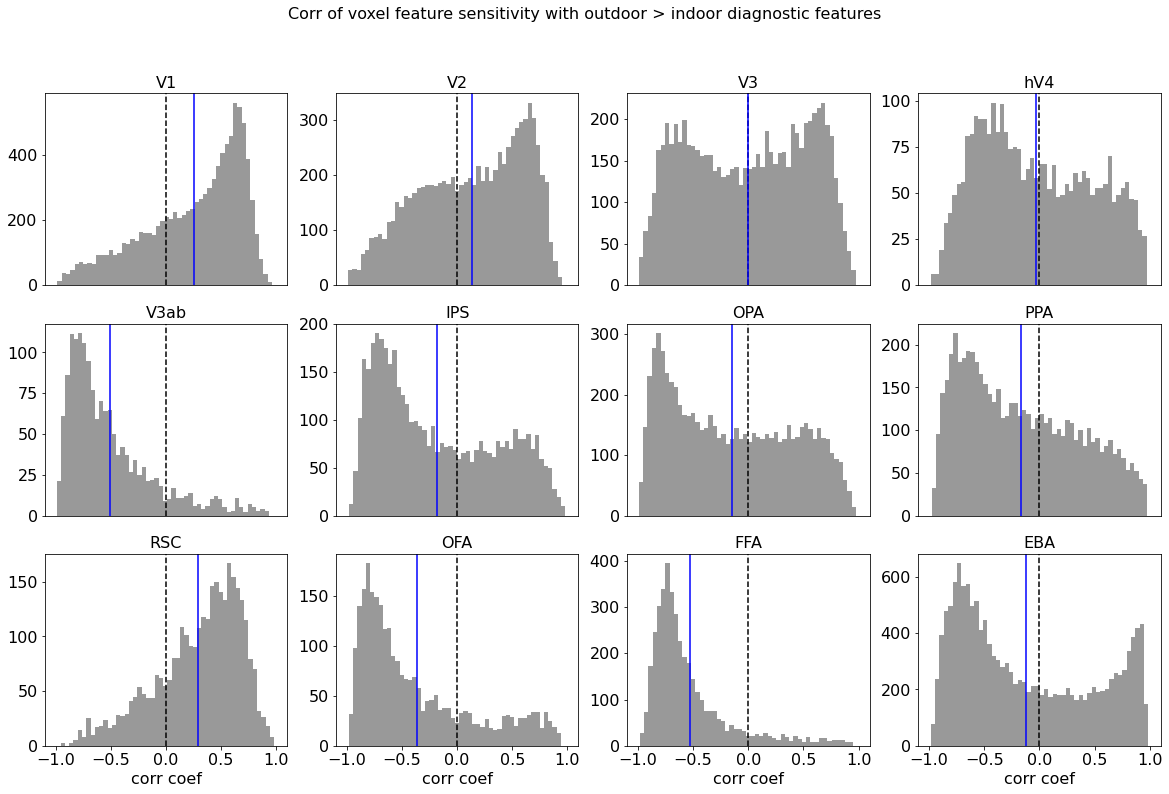

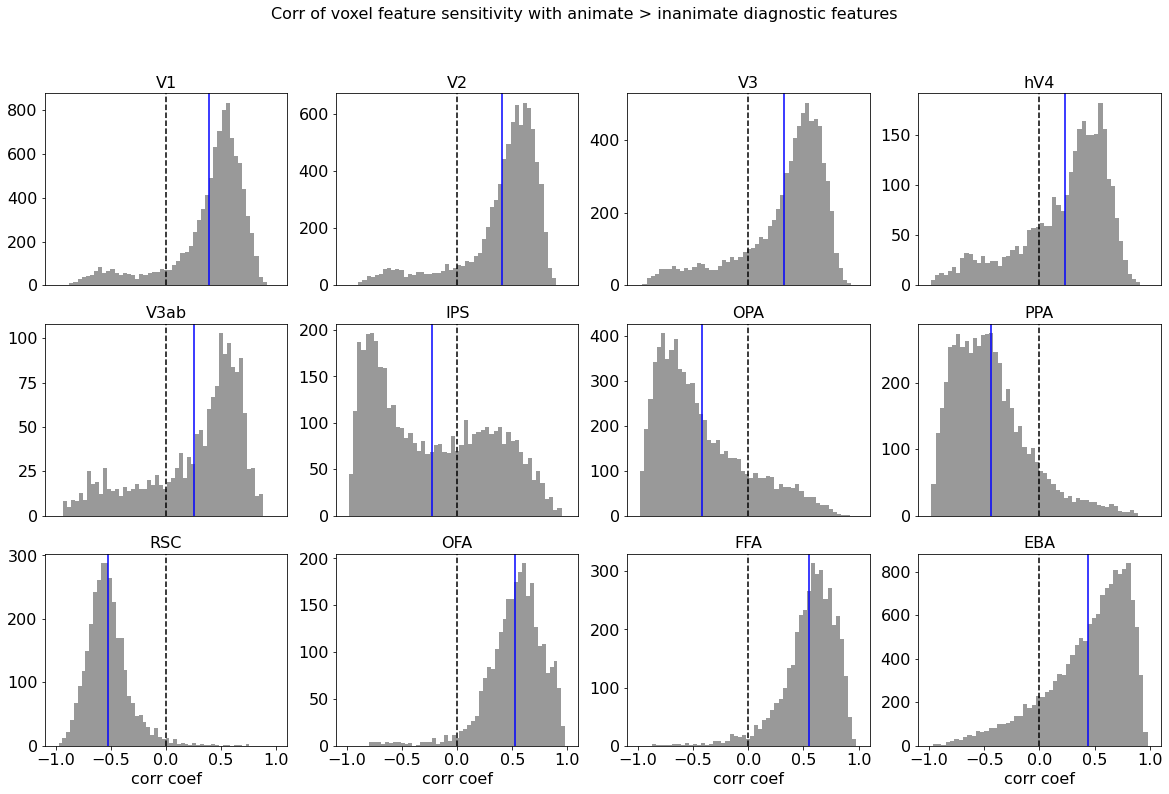

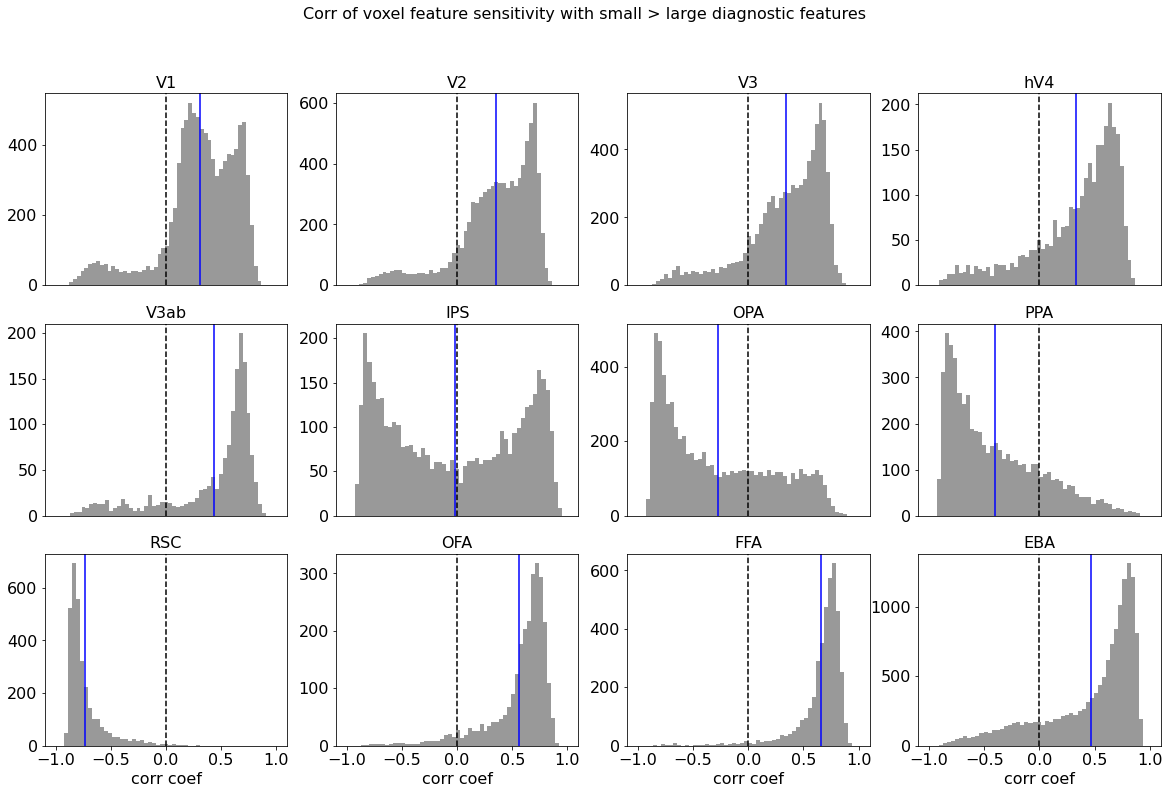

In [55]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42


for dim in [0,1,2]:

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0

    for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

        inds_this_roi = roi_def.get_indices(rr)
        inds_this_roi = inds_this_roi & abv_thresh 

        vals = tuning_dim_corrs[inds_this_roi,dim]

        
        plt.hist(vals, 50, color=[0.6, 0.6, 0.6])
        plt.xlim([-1.1, 1.1])
        plt.axvline(0,linestyle='--',color='k')

        mean = np.mean(vals)
        plt.axvline(mean,color='b')
        
        plt.title(roi_names[rr])

        if rr>7:
            plt.xlabel('corr coef')
        else:
            plt.xticks([])

    plt.suptitle('Corr of voxel feature sensitivity with %s diagnostic features'%(partial_signed_names[dim]))

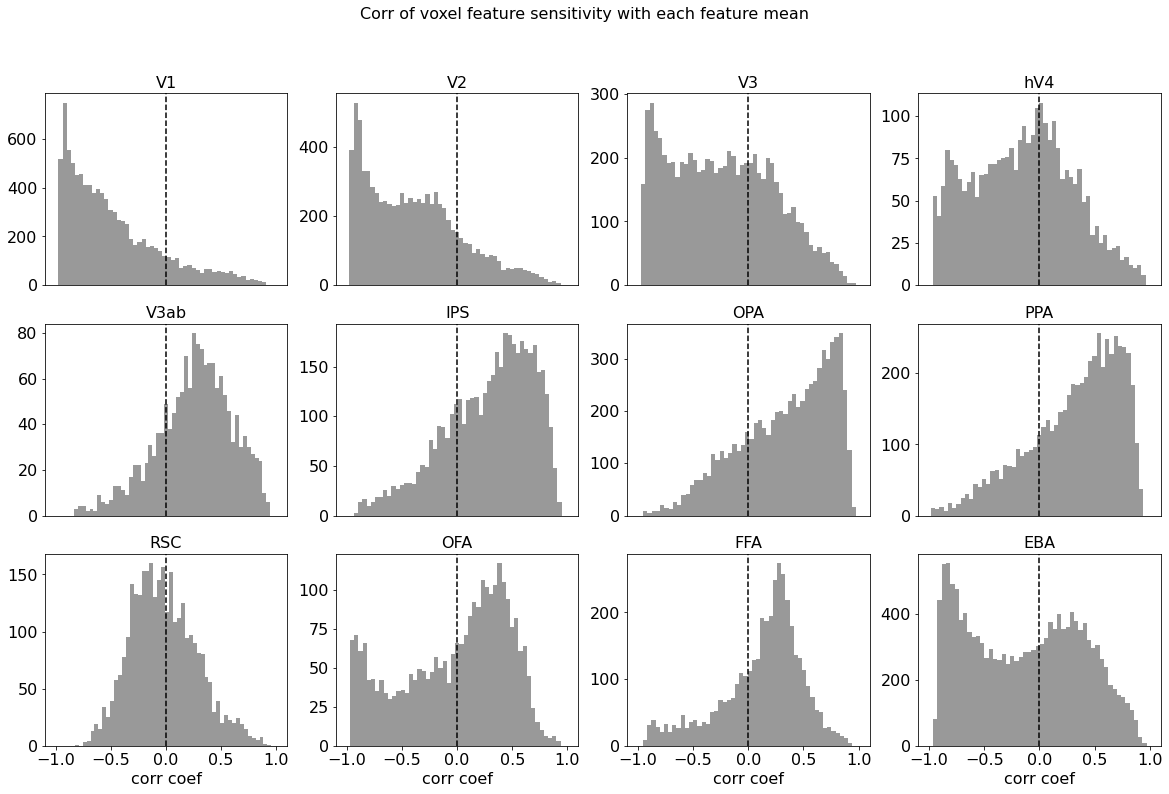

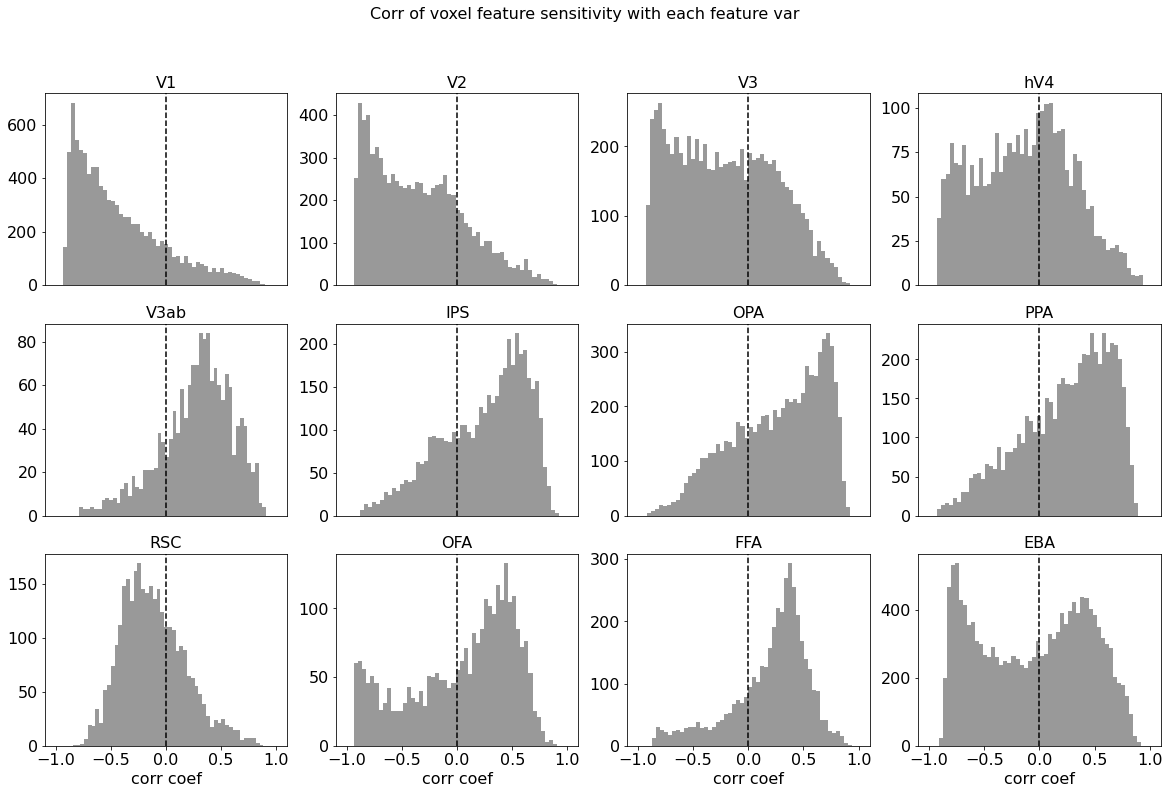

In [56]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for name, tuning_corrs in zip(['mean','var'], [tuning_mean_corrs, tuning_var_corrs]):

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0

    for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

        inds_this_roi = roi_def.get_indices(rr)
        inds_this_roi = inds_this_roi & abv_thresh 

        vals = tuning_corrs[inds_this_roi]

        plt.hist(vals, 50, color=[0.6, 0.6, 0.6])
        plt.xlim([-1.1, 1.1])
        plt.axvline(0,linestyle='--',color='k')

        plt.title(roi_names[rr])

        if rr>7:
            plt.xlabel('corr coef')
        else:
            plt.xticks([])

    plt.suptitle('Corr of voxel feature sensitivity with each feature %s'%name)

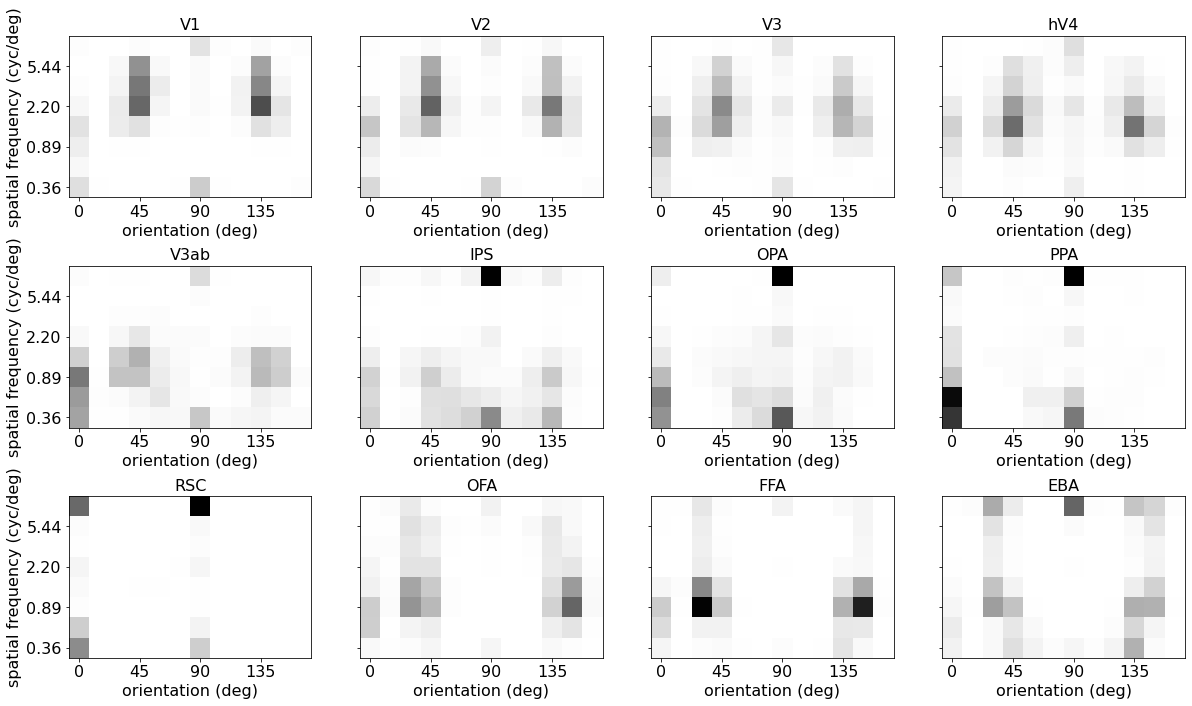

In [58]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0

clims = [0, 0.20]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    inds_this_roi = roi_def.get_indices(rr)
    inds_this_roi = inds_this_roi & abv_thresh 
    
    vals = np.mean(feature_prefs_2dhist[inds_this_roi,:,:], axis=0)
 
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr, npy)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        plt.ylabel('spatial frequency (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
   
    plt.xlabel('orientation (deg)')
    plt.title(roi_names[rr])


Text(0.5, 0.98, 'face - place')

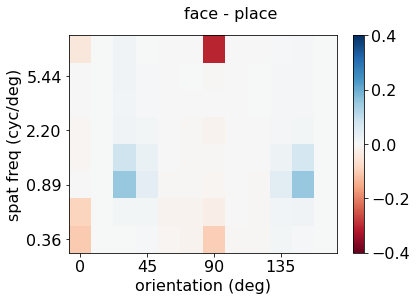

In [72]:
inds_this_roi1 = np.any(np.array([roi_def.get_indices(rr) for rr in rinds1]), axis=0)
inds_this_roi1 = inds_this_roi1 & abv_thresh 
inds_this_roi2 = np.any(np.array([roi_def.get_indices(rr) for rr in rinds2]), axis=0)
inds_this_roi2 = inds_this_roi2 & abv_thresh 
vals1 = np.mean(feature_prefs_2dhist[inds_this_roi1,:,:], axis=0)
vals2 = np.mean(feature_prefs_2dhist[inds_this_roi2,:,:], axis=0)

vals = vals2 - vals1

clims = [-0.4, 0.4]
plt.figure()
# plt.figure(figsize=(12,8))
# plt.subplot(2,2,1)
plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)
plt.xlabel('orientation (deg)')
plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
sf_ticks = sf_unique[[0,2,4,6]].round(2)
plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
plt.ylabel('spat freq (cyc/deg)')
plt.colorbar()

plt.suptitle('face - place')

#### Plot distribution of preferred orientation
Merge voxels over all participants

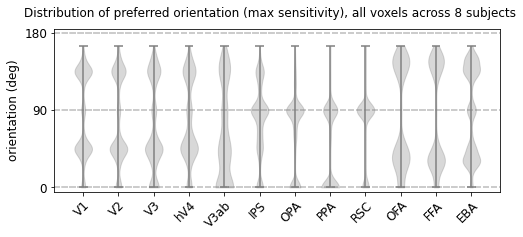

In [40]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'
    
plt.figure(figsize=(8,3))

for ri in range(n_rois):

    
    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.yticks([0,90,180])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    
    plt.ylabel('orientation (deg)')
    plt.ylim([-5, 185])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred orientation (max sensitivity), all voxels across 8 subjects')

fn2save = os.path.join(default_paths.fig_path,'Gabor_orient_violin.pdf')
plt.savefig(fn2save)

#### Same analysis, but determining max over all 96 channels rather than averaging

#### Plot distribution of preferred spatial frequency

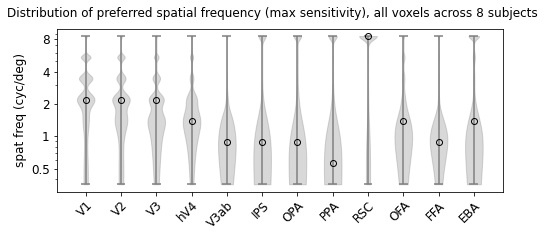

In [6]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

plt.figure(figsize=(8,3))

for ri in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    
    plt.plot(ri, np.median(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)]),\
             marker='o',color='k', markerfacecolor='none')

    # plt.yticks([0,4,8])
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
   
    plt.ylabel('spat freq (cyc/deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred spatial frequency (max sensitivity), all voxels across 8 subjects')

fn2save = os.path.join(default_paths.fig_path,'Gabor_spatfreq_violin.pdf')
plt.savefig(fn2save)

#### Make 2D histograms, out of the two 1d histograms

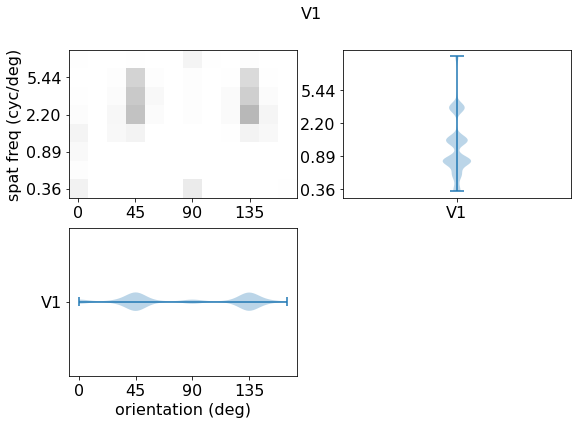

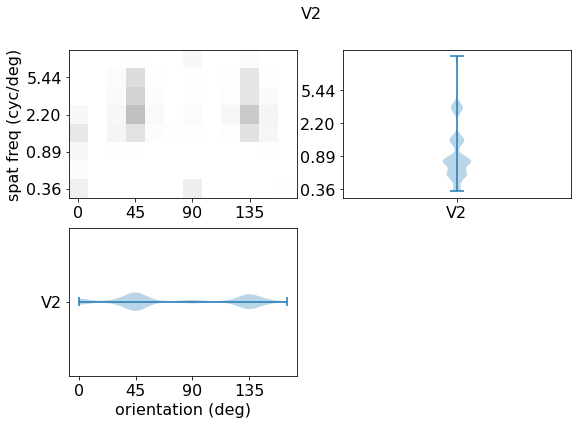

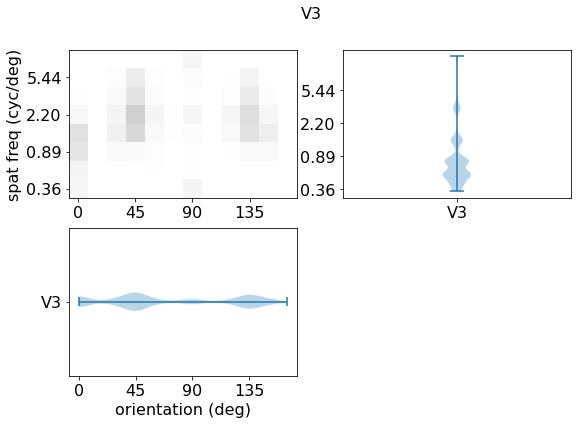

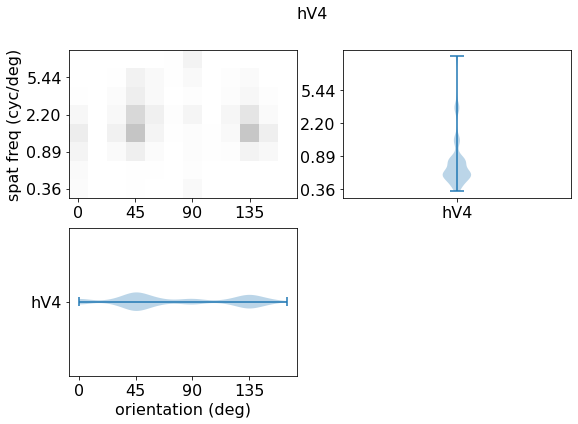

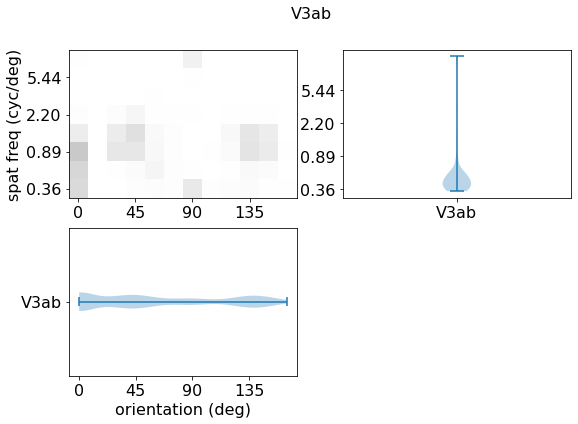

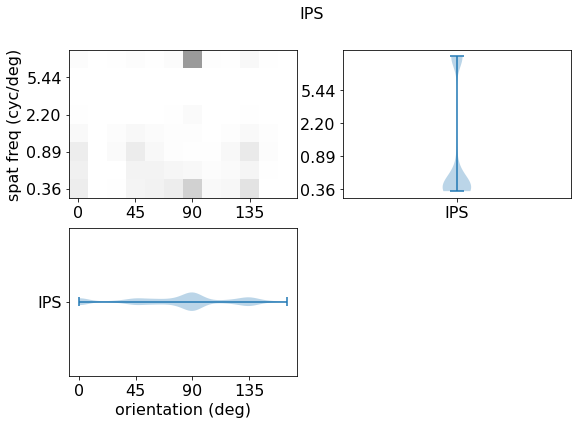

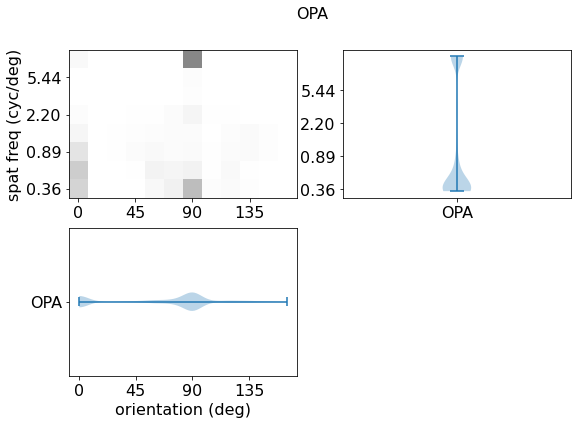

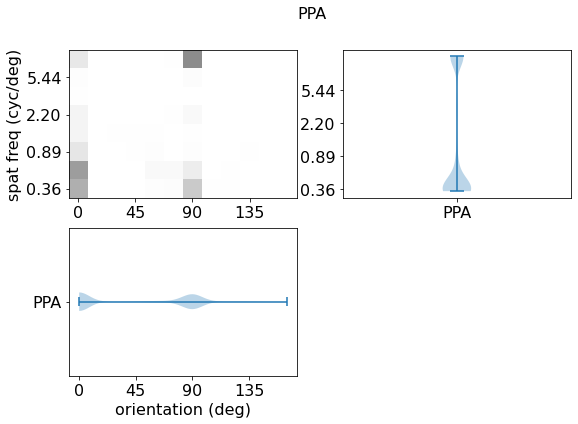

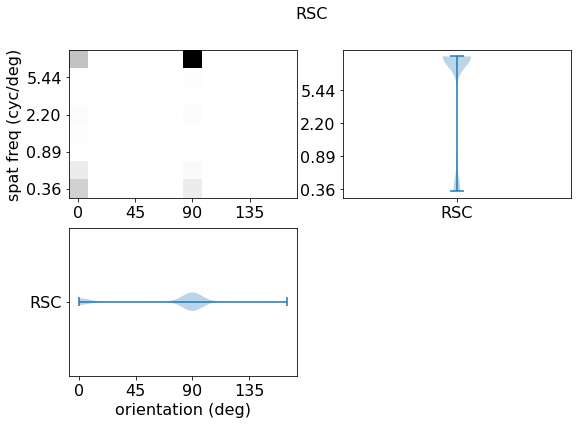

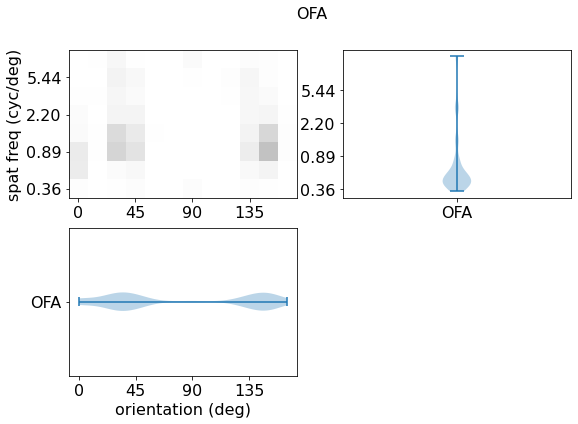

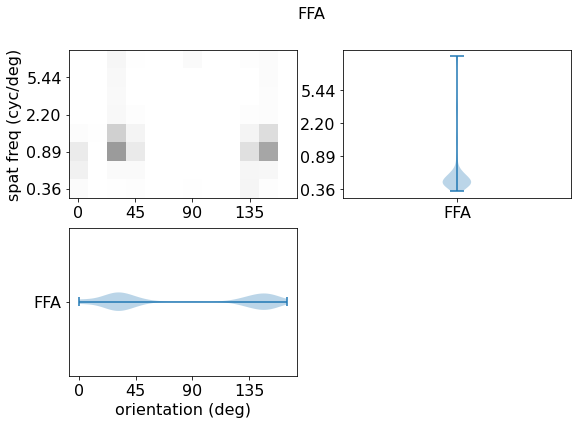

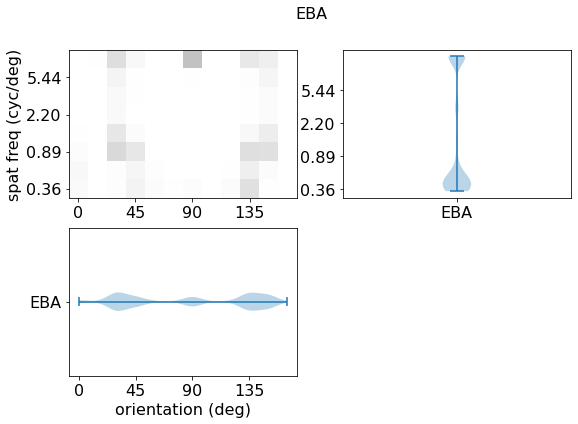

In [69]:
for rr in range(n_rois):

    clims = [0, 0.5]
    inds_this_roi = roi_def.get_indices(rr)
    inds_this_roi = inds_this_roi & abv_thresh 
    vals = feature_prefs_2dhist[inds_this_roi,:,:]

    plt.figure(figsize=(9,6))
    plt.subplot(2,2,1)
    plt.pcolormesh(np.mean(vals, axis=0).T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)
    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
    plt.ylabel('spat freq (cyc/deg)')

    plt.subplot(2,2,2)
    pref_sf = np.argmax(np.sum(vals, axis=1), axis=1).astype(int)
    plt.violinplot(sf_unique[pref_sf], [0])
    plt.xticks([0], [roi_names[rr]])
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
    plt.xlim([-2,2])

    plt.subplot(2,2,3)
    pref_ori = np.argmax(np.sum(vals, axis=2), axis=1).astype(int)
    plt.violinplot(ori_unique[pref_ori], [0], vert=False)
    plt.yticks([0], [roi_names[rr]])
    plt.xticks(np.arange(0,180,45))
    plt.xlabel('orientation (deg)')
    plt.ylim([-2,2])

    plt.suptitle(roi_names[rr])

#### This is a slightly different way of making 2d histograms, similar to above

NameError: name 'feature_prefs_reshaped' is not defined

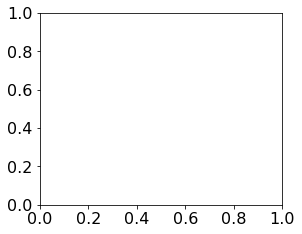

In [70]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0

clims = [0, 0.20]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    inds_this_roi = roi_def.get_indices(rr)
    inds_this_roi = inds_this_roi & abv_thresh 
    
    vals = np.mean(feature_prefs_reshaped[inds_this_roi,:,:], axis=0)
 
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr, npy)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        plt.ylabel('spatial frequency (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
   
    plt.xlabel('orientation (deg)')
    plt.title(roi_names[rr])


In [55]:
np.min(vals)

-0.3051395143474199

In [28]:
feature_prefs_2dhist.shape

NameError: name 'feature_prefs_2dhist' is not defined

In [18]:
vals.shape

(3, 12, 8)

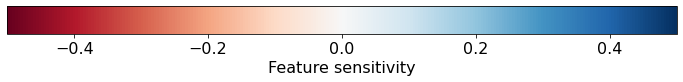

In [12]:
import matplotlib
fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cm.RdBu
norm = matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1])

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
# cb1.set_ticklabels(sf_unique.round(2))
# cb1.set_xlim([0, 8])
cb1.set_label('Feature sensitivity')
fig.show()


#### Plot average orientation sensitivity profiles for each ROI

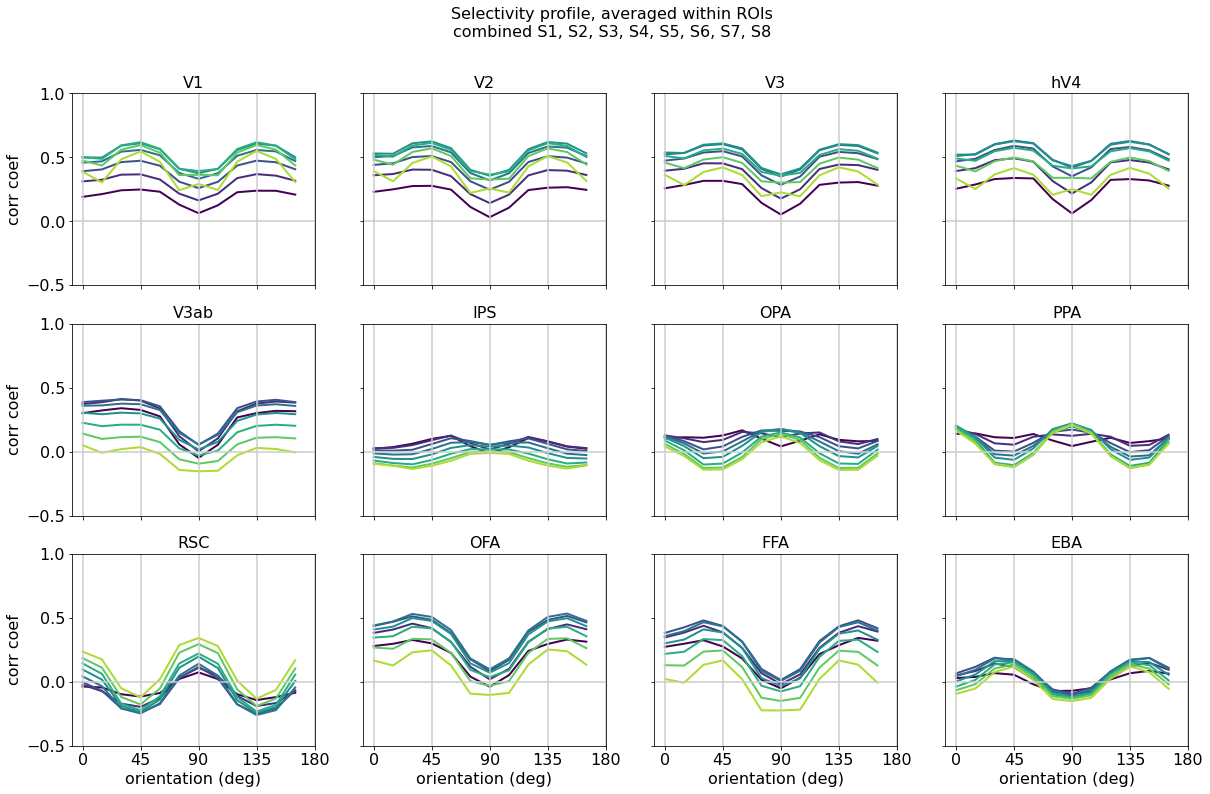

In [8]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals , axis=0)
   
    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
       
        plt.plot(ori_unique,  meanvals, '-',color=colors[sf,:],linewidth=2)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(rr,4)==0:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))

    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>8:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
plt.savefig(fn2save)

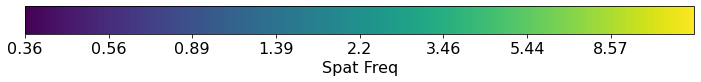

In [9]:
# make colorbar for spat freq color coding
import matplotlib

fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_sf)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=np.arange(n_sf))
cb1.set_ticklabels(sf_unique.round(2))
# cb1.set_xlim([0, 8])
cb1.set_label('Spat Freq')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Freq_colorbar.pdf')
plt.savefig(fn2save)

#### Plot average spatial frequency sensitivity profiles for each ROI

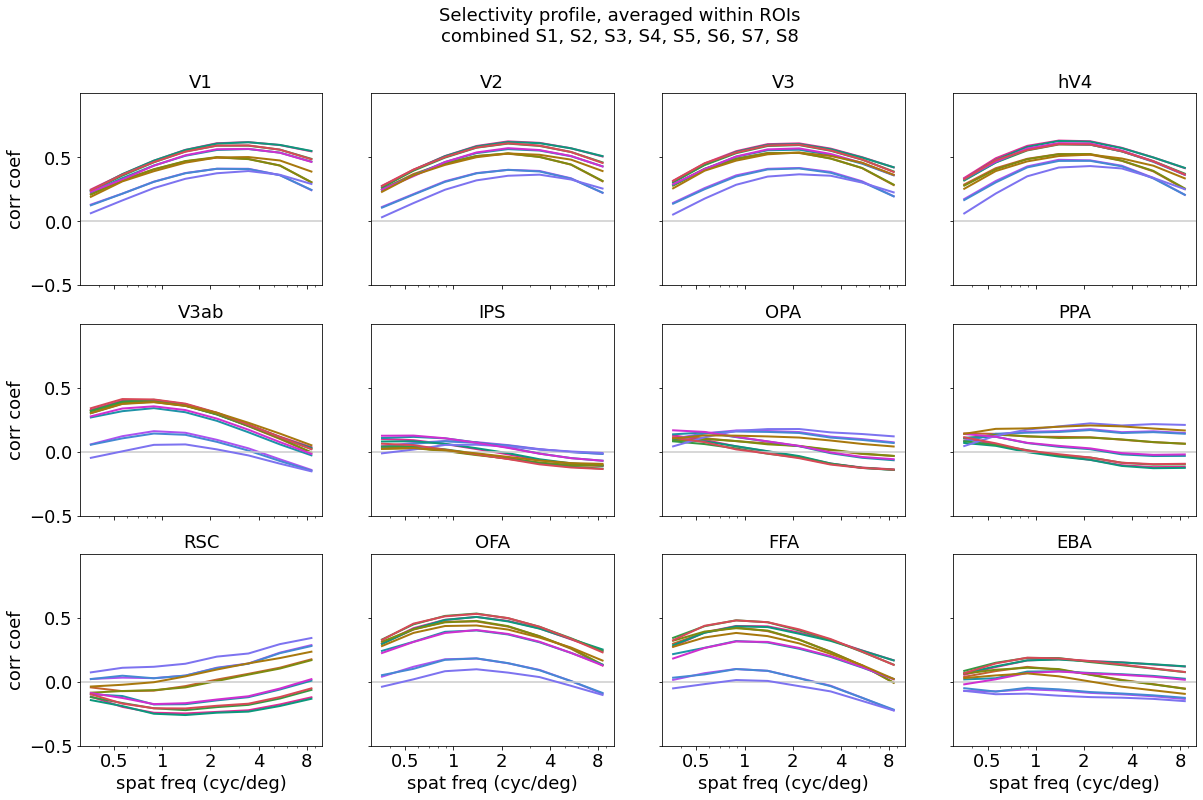

In [9]:
plot_utils.set_all_font_sizes(fs = 18)

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
for rr in range(n_rois):
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals , axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)

        plt.plot(sf_unique,  meanvals, '-',color=colors[oo,:],linewidth=2, zorder=zorders[oo])
        
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if np.mod(pi,4)==1:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1, 0.5), [])
    plt.gca().set_xscale('log')
    if pi>8:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
        plt.xlabel('spat freq (cyc/deg)')
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Freq_sensitivity_allareas.pdf')
plt.savefig(fn2save)


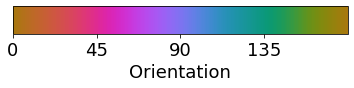

In [10]:
# make colorbar for orientation color coding
import matplotlib

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cmocean.cm.phase
norm = matplotlib.colors.Normalize(vmin=0, vmax=180)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=[0, 45, 90, 135])
cb1.set_label('Orientation')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Orient_colorbar.pdf')
plt.savefig(fn2save)

#### Plot sensitivity profiles for a selected few areas

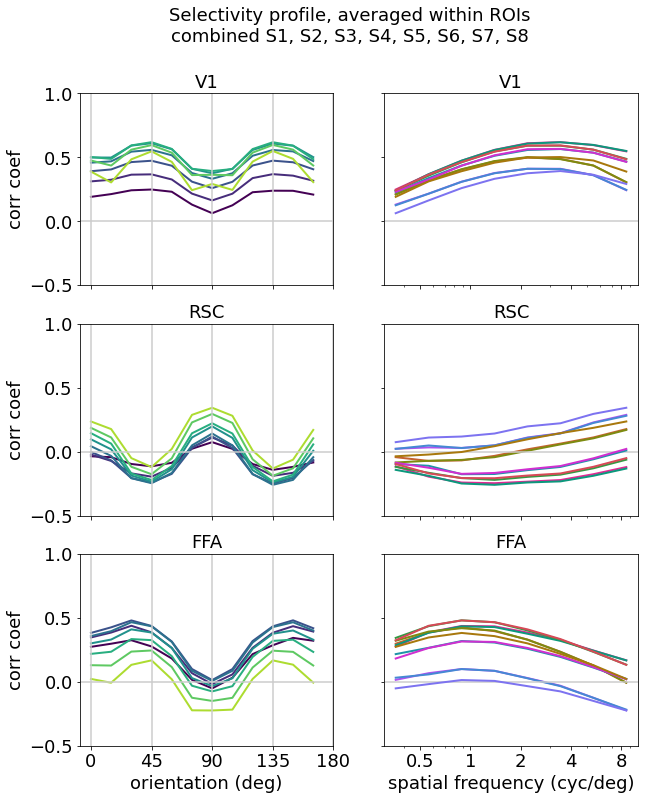

In [11]:
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(10,12))
npx = 3;
npy = 2;

sf_colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

orient_colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
rois2plot = [0,8,10]
for rr in rois2plot:
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
        plt.plot(ori_unique,  meanvals, '-',color=sf_colors[sf,:],linewidth=2)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>4:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))
    
    pi+=1
    plt.subplot(npx,npy,pi)

    # choose the order in which to layer the lines...some of them overlap almost completely, 
    # so this makes it a little easier to see colors
    zorders = np.arange(n_ori, 0, -1)
    zorders[np.arange(1,12,2)]*=(-1)
    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)
        plt.plot(sf_unique,  meanvals, '-',color=orient_colors[oo,:],linewidth=2, \
                 zorder=zorders[oo])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    plt.gca().set_xscale('log')
    if pi>4:
        plt.xlabel('spatial frequency (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Gabor_profiles_selectedareas.pdf')
plt.savefig(fn2save)


#### Compute radial bias: first gather our pRF pars

In [12]:
prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

#### Now make a plot of the correlation bw polar angle pref and orient pref

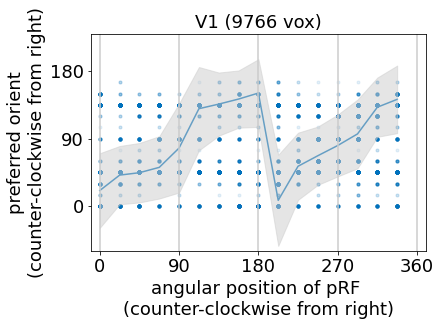

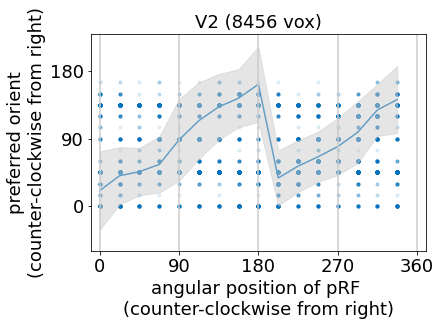

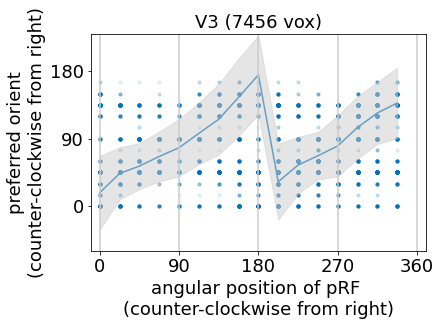

In [13]:
color = '#0071bc'
plt.rcParams['pdf.fonttype']=42

for vv in [0,1,2]:

    r2_cutoff = 0.01
    val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
    abv_thresh = val_r2>r2_cutoff

    vinds = roi_def.get_indices(vv) & abv_thresh

    plt.figure(figsize=(6,4))

    xvals = np.round(angle_fwrf[vinds],1)
    unique_angles, counts = np.unique(xvals, return_counts=True)

    # change the coordinate system of orientation here, so that it matches with 
    # the angular positions (go counter-clockwise from right)
    yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
    # yvals = np.mod(90 - ori_unique[preferred_ori_weights[vinds].astype(int)], 180)  
    yvals_adj = yvals/180*2*np.pi # for circmean/circstd, need range 0-2pi

    ymean = np.array([scipy.stats.circmean(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)
    ystd = np.array([scipy.stats.circstd(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)

    plt.plot(xvals, yvals,'.',color=color, alpha=0.10)

    # plt.errorbar(unique_angles, ymean, ystd, color='k',zorder=10)
    plt.plot(unique_angles, ymean,'-',color=color)
    plt.fill_between(unique_angles, ymean+ystd, ymean-ystd, color=[0.8, 0.8, 0.8] ,alpha=0.5, zorder=10)

    for ii in np.arange(0,370,90):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])

    plt.xticks(np.arange(0,370,90));
    plt.yticks(np.arange(0,190,90));
    plt.xlabel('angular position of pRF \n(counter-clockwise from right)')
    plt.ylabel('preferred orient\n(counter-clockwise from right)')

    plt.xlim([-10, 370])
    plt.ylim([-60, 230])

    plt.title('%s (%d vox)'%(roi_names[vv],np.sum(vinds)))

    fn2save = os.path.join(default_paths.fig_path, '%s_radial_bias.pdf'%roi_names[vv])
    plt.savefig(fn2save)